[ 1 -1  1 ...  1  1  1]
0.47999122738838196
4 iterations were performed
Distances of clusters as compared to last generation: 
[0. 0.]

kmeans:
runtime: 0:00:00.360168
centroids: 
 [-32.81  12.68]
 [ 56.68 -62.61]

sklearn kmeans:
runtime: 0:00:00.052016
centroids: 
 [-32.81  12.68]
 [ 56.68 -62.61]


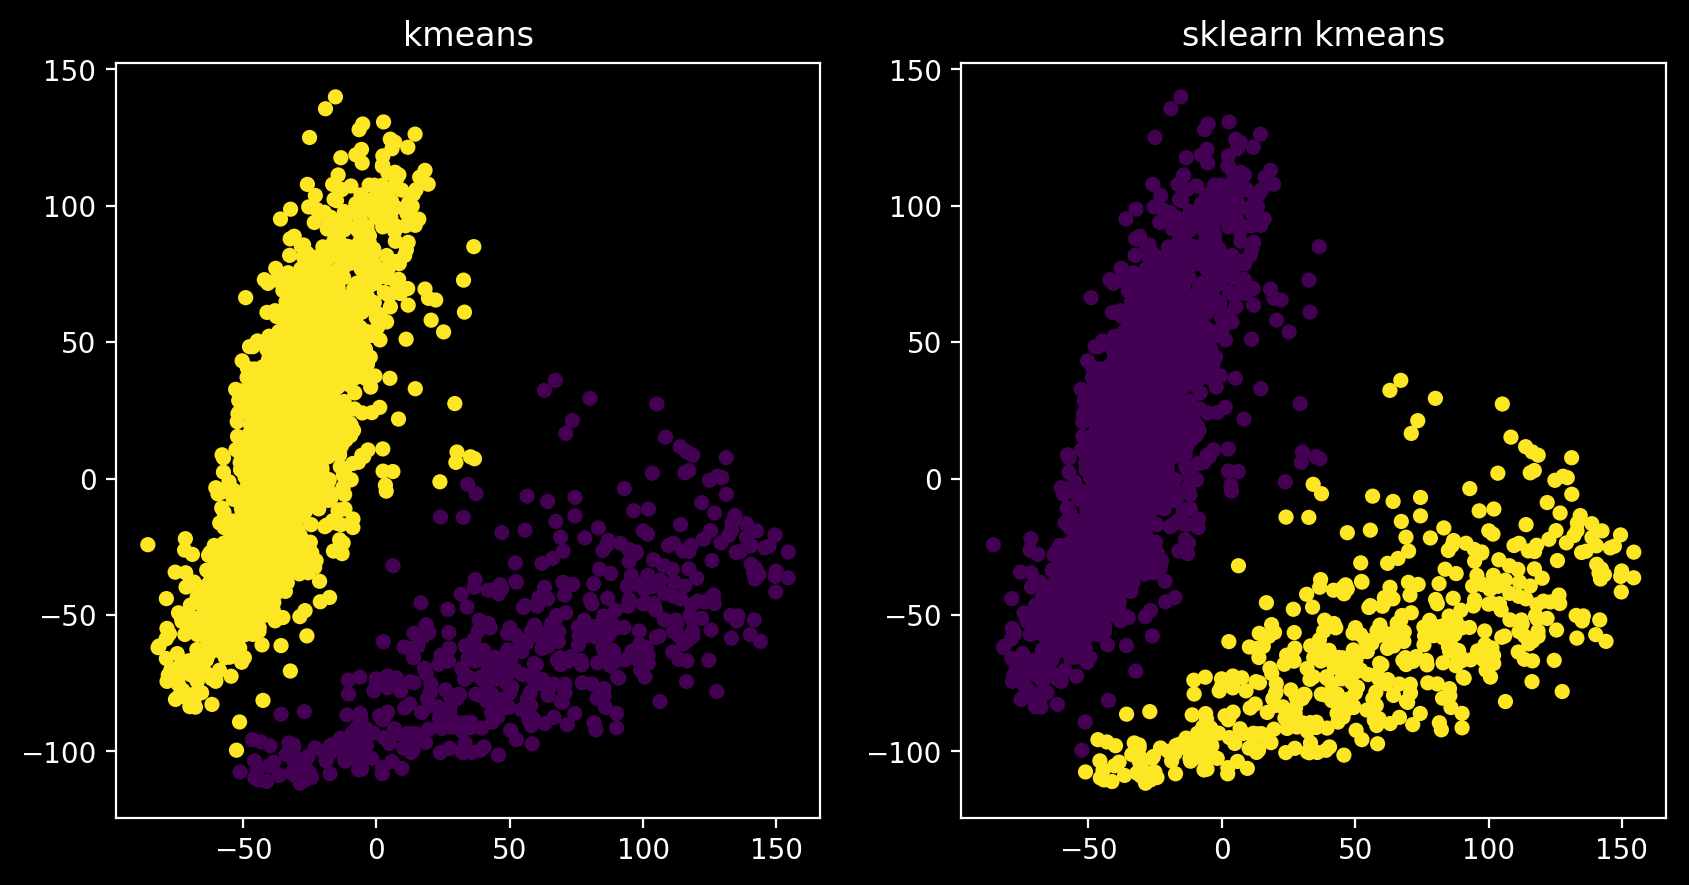

In [2]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest


# Global Variables
t1 = 0
pbmcs = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k pbmcs from data
    global centroids_array, pbmcs, genes
    pbmcs = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(pbmcs, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([pbmcs, 1])
    while i < pbmcs:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array, centroids_oldarray
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    zeros = np.zeros([pbmcs, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1

# Clustering threshold, centroid arrays have the dimension k, genes, repeat until distance is smaller than t
def thresh(t1):
    global centroids_array, centroids_oldarray, k
    t = t1  #threshold to determine when algorythm is done
    i = 0
    c = 1 # add counter to determine how many cycles have passed
    while i < k: 
        a = centroids_array[i,:]
        b = centroids_oldarray[i,:]
        d = np.linalg.norm(a-b)
        if d < t:
            i += 1 
        elif d >= t:
            new_centroids()
            assign_centroids()
            c += 1
    print (str(c) + " iterations were performed")
    # können wir wenn wir wollen dann ans ende von kmeans packen anstelle des while loops


# Function giving distance between clusters after n iterations            
def improv():      
    global centroids_array, centroids_oldarray, k
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))
 

def kmeans(start, k1, n_iterations, t):
    global k
    k = k1
    i = 0
    random_start_centroids(start)
    assign_centroids()
    if start == "randnum":
        empty_check()
    if t == None:
        while i < n_iterations:
            new_centroids()
            assign_centroids()
            i += 1
    else:
        new_centroids()
        assign_centroids()
        thresh(t)
    improv()

# calculates sum of the squared distance in each cluster
def within_square_distance():
        with_sq_dist = np.empty([0,0])
        i = 0
        while (i < 1):
                asigned_centroid = int(nearest_centroid[i-1,0])
                centr_val = centroids_array[asigned_centroid]
                point_val = pca_data[i] 
                i+=1
                sqdist = np.linalg.norm(centr_val - point_val)**2
                with_sq_dist = np.append(with_sq_dist, sqdist)              
        return(sum(with_sq_dist))
    
def remove_outliers():
    global pca_data
    X_train = pca_data
    clf = IsolationForest(max_samples=100, random_state=None, behaviour="new", contamination=.1)
    clf.fit(X_train)
    y_pred_train = clf.predict(X_train)
    print(y_pred_train)
    pca_data = X_train[np.where(y_pred_train == 1, True, False)]

# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
remove_outliers()
print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()

# Startpoint selection [randnum oder randpat], Clusters, Iterations (egal wenn t), Threshhold [float oder None]
kmeans("randnum",2, 10, 0.1)

print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])
